# 5.2 Surfing Pose Estimation

Module - Pose Estimation

For book, references and training materials, please check this project website [http://activefitness.ai/ai-in-sports-with-python](http://activefitness.ai/ai-in-sports-with-python).

Reference: Chapter 7, [Applied Machine Learning for Health and Fitness](https://www.apress.com/us/book/9781484257715)


### Finding keypoints

Let's define functions that help us determine stance. But first, we need to create functions that help locating points in the dataset, calculating Euclidian distance between points and calculating angles: 

In [ ]:
import math
import time
import pandas as pd
from tf_pose import common
import numpy as np

def find_point(pose, p):
    for point in pose:
        try:
            body_part = point.body_parts[p]
            return (int(body_part.x * width + 0.5), int(body_part.y * height + 0.5))
        except:
            return (0,0)
    return (0,0)


### Calculating Euclidian distance and angles

Next, let's define functions to calculate Euclidian distance and angles:

In [2]:
def euclidian(point1, point2):
    return math.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 )

def angle_calc(p0, p1, p2 ):
    try:
        a = (p1[0]-p0[0])**2 + (p1[1]-p0[1])**2
        b = (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2
        c = (p2[0]-p0[0])**2 + (p2[1]-p0[1])**2
        angle = math.acos( (a+b-c) / math.sqrt(4*a*b) ) * 180/math.pi
    except:
        return 0
    return int(angle)

def center_of_mass(pose):
    joints = np.zeros([common.CocoPart.Background.value, 2])

    for p in pose:
        for i in range(common.CocoPart.Background.value):
            if i not in p.body_parts.keys():
                continue
            body_part = p.body_parts[i]
            joints[i] = [body_part.x,body_part.y]
    
    return np.mean(joints, axis=0)


### Determining surfer stance



In [1]:
SK_BOARD_STANCE_GOOFY = "goofy"
SK_BOARD_STANCE_REGULAR = "regular"

def surfing_check_goofy_stance(is_mirror, a, b):
    '''
        is_mirror shows if the camera is mirrored
        a neck L angle
        b neck R angle
    '''
    if not is_mirror:
        if a > b:
            return SK_BOARD_STANCE_GOOFY
        return SK_BOARD_STANCE_REGULAR
    else:
        if a > b:
            return SK_BOARD_STANCE_REGULAR
        return SK_BOARD_STANCE_GOOFY
    
def detect_stance(is_mirror, pose):
    l = angle_calc(find_point(pose,0), find_point(pose,1), find_point(pose,11))
    r = angle_calc(find_point(pose,0), find_point(pose,1), find_point(pose,8))
    
    return surfing_check_goofy_stance(is_mirror, l, r)

Now, it's time to import TensorFlow and supporting modules:

In [4]:
import sys
import time
import os

from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
import math

import matplotlib.pyplot as plt
%matplotlib inline

BOARD_STANCE_GOOFY = "goofy"
BOARD_STANCE_REGULAR = "regular"

model = "cmu"
image_file = "media/surfer_656x368.jpg"
experiments_dir = "_experiments/"

def draw_str(dst, s, color, scale):
    
    (x, y) = (10,20)

    if (color[0]+color[1]+color[2]==255*3):
        cv2.putText(dst, s, (x+1, y+1), cv2.FONT_HERSHEY_SIMPLEX, scale, (0, 0, 0))
    else:
        cv2.putText(dst, s, (x+1, y+1), cv2.FONT_HERSHEY_SIMPLEX, scale, color)
    #cv2.line    
    cv2.putText(dst, s, (x, y), cv2.FONT_HERSHEY_SIMPLEX, scale, (255, 255, 255))

def init_experiments_dir(experiments_dir = "_experiments/"):
    if not os.path.exists(experiments_dir):
        os.makedirs(experiments_dir)

    experiment_dir = time.strftime("%Y%m%d-%H%M%S")
    out_dir = experiments_dir + experiment_dir
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    output_json = out_dir + "/json/"
    if not os.path.exists(output_json):
        os.makedirs(output_json)
    return out_dir, output_json



Initialize pose estimator and read the image:


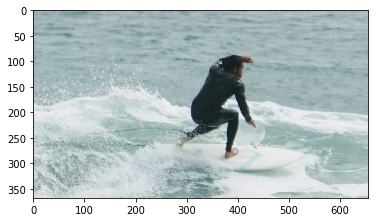

In [5]:
# initialize and load images
out_dir, output_json = init_experiments_dir(experiments_dir)
image = common.read_imgfile(image_file, None, None)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
# load estimator
h, w, channels = image.shape

if w == 0 or h == 0:
    e = TfPoseEstimator(get_graph_path('cmu'), target_size=(432, 368))
else:
    e = TfPoseEstimator(get_graph_path('cmu'), target_size=(w, h))

[2019-10-01 19:16:31,866] [TfPoseEstimator] [INFO] loading graph from C:\ProgramData\Anaconda3\lib\site-packages\tf_pose-0.1.1-py3.7-win-amd64.egg\tf_pose_data\graph/cmu/graph_opt.pb(default size=656x368)


Instructions for updating:
Colocations handled automatically by placer.


Start inference and estimate the stance

inference started...
STANCE goofy


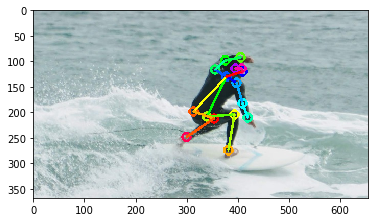

In [7]:
print('inference started...')
t = time.time()
pose = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)

print("STANCE "+ detect_stance(True, pose))

image = TfPoseEstimator.draw_humans(image, pose, imgcopy=False, output_json_dir=out_dir )    
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()